In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
input_image = "/content/drive/MyDrive/ML/Fine tune/image_sample.jpg"

In [3]:
from diffusers import StableDiffusionPipeline
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# import torch

# model_id = "runwayml/stable-diffusion-v1-5"
# pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)
# pipe = pipe.to("cuda")

In [10]:
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float32
).to("cuda")

init_image = Image.open(input_image).convert("RGB").resize((512,512))

# prompt = "convert to anime style"
# image = pipe(prompt=prompt, image=init_image, strength=0.8, guidance_scale=7.5).images[0]

# image.save("anime_style.png")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [11]:
image = Image.open(input_image).convert("RGB").resize((512,512))
image_tensor = torch.from_numpy(np.array(image)).permute(2, 0, 1).unsqueeze(0).to("cuda",dtype=torch.float32) / 255.0
vae_encoding = pipe.vae.encode(image_tensor * 2 - 1).latent_dist.sample() * 0.18215

In [12]:
noise = torch.randn_like(vae_encoding).to("cuda")

In [22]:
strength  = 1
pipe.scheduler.set_timesteps(50)
timesteps = pipe.scheduler.timesteps
t_start = timesteps[int(strength * (len(timesteps) - 1))]

noisy_image = pipe.scheduler.add_noise(vae_encoding,noise,torch.tensor([t_start], device=vae_encoding.device))
noisy_image = noisy_image

In [23]:
#Fixed text input given
# fixed_prompt = "anime style, highly detailed illustration, clean line art, vibrant colors, sharp shading, masterpiece"
# negative_prompt = "blurry, low quality, distorted, deformed, extra limbs, bad anatomy"
# text_encoder = pipe.text_encoder
# tokenizer = pipe.tokenizer
# text_inputs = tokenizer(fixed_prompt, return_tensors="pt", padding=True, truncation=True).to("cuda")
# prompt_embedding = text_encoder(text_inputs.input_ids)[0]

guidance_scale = 7.5

# Tokenize conditional (your prompt)
text_input = pipe.tokenizer("convert to anime style", return_tensors="pt",).to("cuda")
prompt_embeds = pipe.text_encoder(**text_input).last_hidden_state

# Tokenize unconditional (empty string)
uncond_input = pipe.tokenizer(["blurry, low quality, distorted, deformed, extra limbs, bad anatomy"], max_length=6,truncation=True,return_tensors="pt").to("cuda")
uncond_embeds = pipe.text_encoder(**uncond_input).last_hidden_state

# Concatenate for CFG

print(uncond_embeds.shape,prompt_embeds.shape)
embeds = torch.cat([uncond_embeds, prompt_embeds])


torch.Size([1, 6, 768]) torch.Size([1, 6, 768])


In [24]:
# for t in timesteps:
#     latent_model_input = pipe.scheduler.scale_model_input(noisy_image, t)

#     with torch.no_grad():
#         # UNet predicts the noise residual
#         noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=prompt_embedding).sample

#     # Scheduler steps to compute the previous sample (x_t → x_{t-1})
#     latents = pipe.scheduler.step(noise_pred, t, noisy_image).prev_sample


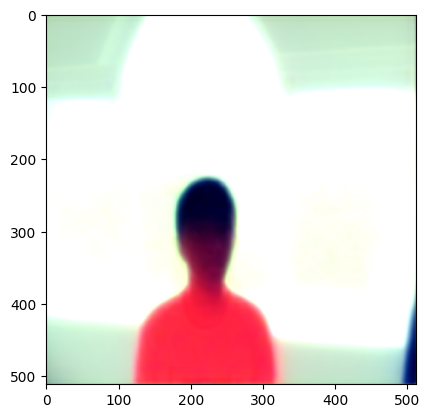

In [25]:
latents = noisy_image.clone()
for t in pipe.scheduler.timesteps:
    latent_model_input = pipe.scheduler.scale_model_input(latents, t)

    # Duplicate latents for unconditional + conditional
    latent_model_input = latent_model_input.repeat(2, 1, 1, 1)

    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=embeds).sample

    # Split predictions
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)

    # CFG step
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Scheduler update
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample


# Decode with VAE
image = pipe.vae.decode(latents / 0.18215).sample
image = (image.clamp(-1, 1) + 1) / 2
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
plt.imshow(image[0])